## Import


In [ ]:
import time

start_time = time.time()
print("Start time:", time.ctime(start_time))
from datetime import datetime

Start time: Fri Jul 25 17:48:12 2025


In [ ]:
import pandas as pd
from mlxtend.frequent_patterns import apriori
from mlxtend.preprocessing import TransactionEncoder
from itertools import combinations

import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import random
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

import os
import json

import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import files

    Note: Change paths

In [ ]:
testpath = 'HYPER_university_test_data.csv'
trainpath = 'HYPER_university_train_data.csv'
valpath = 'HYPER_university_val_data.csv'

## Rhapsody Implementation

In [ ]:
def rhapsody_algorithm(data_path, T, K):
    """
    Rhapsody Algorithm for ABAC Policy Mining

    Parameters:
    - data_path: Path to CSV file with columns ['userID', 'resourceID', 'operation']
    - T: Minimum request coverage threshold (≥ 1)
    - K: Reliability threshold (∈ [0, 1])

    When to use T and K:
    - T: Use to filter out rules that cover too few requests (noise filtering)
      - Higher T = more conservative, fewer but more significant rules
      - Lower T = more permissive, more rules including rare patterns
    - K: Use to ensure rule reliability/confidence
      - Higher K = more reliable rules, stricter quality control
      - Lower K = more permissive, allows less reliable rules
    """

    # Load and prepare data
    data = pd.read_csv(data_path)
    print(f"Loaded {len(data)} records")

    # STAGE 1: Compute FreqRules, nU×P, and nA
    print("\n=== STAGE 1: Computing Frequent Rules ===")
    freq_rules, nUP, nA = stage1(data, T)

    # STAGE 2: Compute RelRules (T-reliable rules)
    print("\n=== STAGE 2: Computing Reliable Rules ===")
    rel_rules = stage2(freq_rules, nUP, nA, T, K)

    # STAGE 3: Remove redundant rules
    print("\n=== STAGE 3: Removing Redundant Rules ===")
    short_rules = stage3(rel_rules, nUP, nA, freq_rules)

    return short_rules, nUP, nA

In [ ]:
def stage1(data, T):
    """
    Stage 1: Compute FreqRules, nU×P, and nA
    """

    # Each atom represents an attribute-value pair that a request satisfies
    data['atoms'] = data.apply(lambda row: frozenset([
        f"operation={row['operation']}",
        f"user_role={row['user_role']}",
        f"resource_type={row['resource_type']}",
        f"crs_taught={row['crs_taught']}"
    ]), axis=1)

    # Step 2: Create transaction list
    transactions = list(data['atoms'])
    print(f"Created {len(transactions)} transactions")

    # Step 3: Apply APRIORI with threshold T
    te = TransactionEncoder()
    te_array = te.fit(transactions).transform(transactions)
    df_encoded = pd.DataFrame(te_array, columns=te.columns_)

    # Calculate minimum support as T/total_transactions
    min_support = T / len(transactions)
    print(f"Minimum support: {min_support:.4f} (T={T}, total transactions={len(transactions)})")

    # Get frequent itemsets
    freq_itemsets = apriori(df_encoded, min_support=min_support, use_colnames=True)

    if freq_itemsets.empty:
        print("No frequent itemsets found with the given threshold")
        return [], {}, {}

    # Step 4: Convert itemsets to rules (FreqRules)
    freq_rules = []
    nUP = {}  # nU×P function

    for _, row in freq_itemsets.iterrows():
        itemset = row['itemsets']
        rule = " ∧ ".join(sorted(itemset))
        freq_rules.append(rule)

        # Count requests covered by this rule (support * total transactions)
        nUP[rule] = int(row['support'] * len(transactions))

    print(f"Generated {len(freq_rules)} frequent rules")

    # Step 5: Compute nA
    nA = {}
    for rule in freq_rules:
        nA[rule] = len(rule.split(" ∧ "))

    # Initialize nA to 0
    for rule in freq_rules:
        nA[rule] = 0

    # This counts how many attribute assignments each rule covers
    for _, row in data.iterrows():
        operation_attr = f"operation={row['operation']}"
        user_role_attr = f"user_role={row['user_role']}"
        resource_type_attr = f"resource_type={row['resource_type']}"
        crs_taught_attr = f"crs_taught={row['crs_taught']}"

        request_atoms = {operation_attr, user_role_attr, resource_type_attr , crs_taught_attr}

        for rule in freq_rules:
            rule_atoms = set(rule.split(" ∧ "))
            if rule_atoms.issubset(request_atoms):
                nA[rule] += 1

    print(f"\nSample nA values:")
    for i, rule in enumerate(freq_rules[:3]):
          print(f"  Rule {i+1}: {rule}")
          print(f"    nU×P = {nUP[rule]} (requests covered)")
          print(f"    nA = {nA[rule]} (attribute combinations satisfied)")

    return freq_rules, nUP, nA

In [ ]:
def stage2(freq_rules, nUP, nA, T, K):
    """
    Stage 2: Compute RelRules (rules with T-reliability ≥ K)
    """
    unrel_rules = set()

    # Check all pairs of rules
    for r1 in freq_rules:
        for r2 in freq_rules:
            if r1 != r2:
                # Check if r2 proves that RelT(r1) < K
                if proves_unreliability(r1, r2, nUP, T, K):
                    unrel_rules.add(r1)

    # Compute RelRules = FreqRules \ UnrelRules
    rel_rules = [rule for rule in freq_rules if rule not in unrel_rules]

    print(f"Unreliable rules: {len(unrel_rules)}")
    print(f"Reliable rules: {len(rel_rules)}")

    return rel_rules

def proves_unreliability(r1, r2, nUP, T, K):
    """
    Check if r2 proves that RelT(r1) < K

    Conditions:
    (i) r2 is a refinement of r1 (r1 ⊆ r2)
    (ii) |r2_U×P| ≥ T
    (iii) Conf(r2) < K
    """
    r1_atoms = set(r1.split(" ∧ "))
    r2_atoms = set(r2.split(" ∧ "))

    # (i) r2 is a refinement of r1 (r1 is subset of r2)
    if not r1_atoms.issubset(r2_atoms):
        return False

    # (ii) r2 covers at least T requests
    if nUP[r2] < T:
        return False

    # (iii) Confidence of r2 < K (Normalized Confidence)
    # Conf(r2) = |r2_U×P| / (|r1_U×P| + |r2_U×P|)
    confidence = nUP[r2] / (nUP[r1] + nUP[r2])

    if confidence < K:
        return True

    return False

In [ ]:
def stage3(rel_rules, nUP, nA, freq_rules):
    """
    Stage 3: Remove redundant rules
    """
    subsumed = set()

    # Check all pairs of rules in RelRules
    for r1 in rel_rules:
        for r2 in rel_rules:
            if r1 != r2:
                # Check if r1 and r2 are equivalent and r2 is shorter
                if are_equivalent(r1, r2, nUP, freq_rules) and is_shorter(r2, r1):
                    subsumed.add(r2)

    # Compute ShortRules = RelRules \ Subsumed
    short_rules = [rule for rule in rel_rules if rule not in subsumed]

    # Sort by number of attributes
    short_rules = sorted(short_rules, key=lambda x: nA[x])

    print(f"Subsumed rules: {len(subsumed)}")
    print(f"Final concise rules: {len(short_rules)}")

    return short_rules

def are_equivalent(r1, r2, nUP, freq_rules):
    """
    Simplified equivalence: rules are equivalent if they have same coverage
    and one subsumes the other
    """
    if nUP[r1] != nUP[r2]:
        return False

    r1_atoms = set(r1.split(" ∧ "))
    r2_atoms = set(r2.split(" ∧ "))

    # If one rule's conditions are a subset of the other's, they're equivalent
    # when they have the same coverage
    return r1_atoms.issubset(r2_atoms) or r2_atoms.issubset(r1_atoms)

def is_shorter(r2, r1):
    """
    Check if r2 is shorter than r1 (has fewer attributes/conditions)
    """
    r1_atoms = r1.split(" ∧ ")
    r2_atoms = r2.split(" ∧ ")
    return len(r2_atoms) < len(r1_atoms)

In [ ]:
def display_results(rules, nUP, nA, title):
    """Display rules with their statistics"""
    print(f"\n{title}:")
    if not rules:
        print("No rules found.")
        return

    for rule in rules:
        print(f"{rule}  |  nU×P: {nUP[rule]}  |  nA: {nA[rule]}")

#### Rhapsody for Hyperparameter Search

In [ ]:
def hyperparams_rhapsody_algorithm(data_path, T, K):
    """ Short version: Rhapsody Algorithm for ABAC Policy Mining"""
    data = pd.read_csv(data_path)
    freq_rules, nUP, nA = stage1(data, T)
    rel_rules = stage2(freq_rules, nUP, nA, T, K)
    short_rules = stage3(rel_rules, nUP, nA, freq_rules)
    return short_rules, nUP, nA

def stage1(data, T):
    data['atoms'] = data.apply(lambda row: frozenset([
        f"operation={row['operation']}",
        f"user_role={row['user_role']}",
        f"resource_type={row['resource_type']}",
        f"crs_taught={row['crs_taught']}"
    ]), axis=1)

    transactions = list(data['atoms'])
    te = TransactionEncoder()
    te_array = te.fit(transactions).transform(transactions)
    df_encoded = pd.DataFrame(te_array, columns=te.columns_)
    min_support = T / len(transactions)
    freq_itemsets = apriori(df_encoded, min_support=min_support, use_colnames=True)

    if freq_itemsets.empty:
        print("No frequent itemsets found with the given threshold")
        return [], {}, {},{}

    freq_rules = []
    nUP = {}
    for _, row in freq_itemsets.iterrows():
        itemset = row['itemsets']
        rule = " ∧ ".join(sorted(itemset))
        freq_rules.append(rule)
        nUP[rule] = int(row['support'] * len(transactions))

    nA = {}
    for rule in freq_rules:
        nA[rule] = len(rule.split(" ∧ "))
    for rule in freq_rules:
        nA[rule] = 0

    for _, row in data.iterrows():
        operation_attr = f"operation={row['operation']}"
        user_role_attr = f"user_role={row['user_role']}"
        resource_type_attr = f"resource_type={row['resource_type']}"
        crs_taught_attr = f"crs_taught={row['crs_taught']}"
        request_atoms = {operation_attr, user_role_attr, resource_type_attr , crs_taught_attr}

        for rule in freq_rules:
            rule_atoms = set(rule.split(" ∧ "))
            if rule_atoms.issubset(request_atoms):
                nA[rule] += 1
    return freq_rules, nUP, nA

def stage2(freq_rules, nUP, nA, T, K):
    unrel_rules = set()
    for r1 in freq_rules:
        for r2 in freq_rules:
            if r1 != r2:
                if proves_unreliability(r1, r2, nUP, T, K):
                    unrel_rules.add(r1)
    rel_rules = [rule for rule in freq_rules if rule not in unrel_rules]

    return rel_rules

def proves_unreliability(r1, r2, nUP, T, K):
    r1_atoms = set(r1.split(" ∧ "))
    r2_atoms = set(r2.split(" ∧ "))
    if not r1_atoms.issubset(r2_atoms):
        return False
    if nUP[r2] < T:
        return False
    confidence = nUP[r2] / (nUP[r1] + nUP[r2])
    if confidence < K:
        return True
    return False

def stage3(rel_rules, nUP, nA, freq_rules):
    subsumed = set()
    for r1 in rel_rules:
        for r2 in rel_rules:
            if r1 != r2:
              if are_equivalent(r1, r2, nUP, freq_rules) and is_shorter(r2, r1):
                    subsumed.add(r1)
    short_rules = [rule for rule in rel_rules if rule not in subsumed]
    short_rules = sorted(short_rules, key=lambda x: nA[x])
    print(f"Final concise rules: {len(short_rules)}\n\n")
    return short_rules

def are_equivalent(r1, r2, nUP, freq_rules):
    """
    Simplified equivalence: rules are equivalent if they have same coverage
    and one subsumes the other
    """
    if nUP[r1] != nUP[r2]:
        return False

    r1_atoms = set(r1.split(" ∧ "))
    r2_atoms = set(r2.split(" ∧ "))

    # If one rule's conditions are a subset of the other's, they're equivalent
    # when they have the same coverage
    return r1_atoms.issubset(r2_atoms) or r2_atoms.issubset(r1_atoms)

def is_shorter(r2, r1):
    """
    Check if r2 is shorter than r1 (has fewer attributes/conditions)
    """
    r1_atoms = r1.split(" ∧ ")
    r2_atoms = r2.split(" ∧ ")
    return len(r2_atoms) < len(r1_atoms)

## Hyperparameter Search

### Visualization

In [ ]:
def plot_confusion_matrices(results_df, metric, top_n=4):
    """Plot confusion matrices for the best performing parameter combinations"""

    metric = 'f1_score' if not metric else metric
    valid_results = results_df[results_df['rules_count'] > 0].copy()

    if valid_results.empty:
        print("No valid results to plot confusion matrices!")
        return

    # Sort by the specified metric and get top N
    top_results = valid_results.nlargest(top_n, metric)

    # Calculate grid size
    n_plots = len(top_results)
    if n_plots == 1:
        rows, cols = 1, 1
    elif n_plots <= 2:
        rows, cols = 1, 2
    elif n_plots <= 4:
        rows, cols = 2, 2
    else:
        rows = int(np.ceil(n_plots / 3))
        cols = 3

    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))

    # Handle single subplot case
    if n_plots == 1:
        axes = [axes]
    elif rows == 1 or cols == 1:
        axes = axes.flatten() if hasattr(axes, 'flatten') else [axes]
    else:
        axes = axes.flatten()

    for idx, (_, row) in enumerate(top_results.iterrows()):
        if idx >= len(axes):
            break

        ax = axes[idx]

        # Get true and predicted labels
        y_true = row['y_true']
        y_pred = row['y_pred']

        if len(y_true) == 0 or len(y_pred) == 0:
            ax.text(0.5, 0.5, 'No data available', ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'T={row["T"]}, K={row["K"]:.1f}\nNo Data')
            continue

        # Create confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        cm = cm[::-1, ::-1] #change order of denied, allowed

        # Plot heatmap
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                    xticklabels=['Allowed', 'Denied'],
                    yticklabels=['Allowed', 'Denied']
                    )

        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')
        ax.set_title(f'T={row["T"]}, K={row["K"]:.1f}\n'
                    f'{metric.replace("_", " ").title()}: {row[metric]:.3f}')

    # Hide empty subplots
    for idx in range(n_plots, len(axes)):
        axes[idx].axis('off')

    plt.suptitle(f'Confusion Matrices - Top {n_plots} by {metric.replace("_", " ").title()}',
                 fontsize=16, y=0.98)
    plt.tight_layout()
    plt.show()

def plot_detailed_confusion_matrix(results_df, T_val, K_val):
    """Plot a detailed confusion matrix for specific T and K values"""

    # Find the specific result
    result = results_df[(results_df['T'] == T_val) & (abs(results_df['K'] - K_val) < 0.01)]

    if result.empty:
        print(f"No results found for T={T_val}, K={K_val}")
        return

    result = result.iloc[0]

    if result['rules_count'] == 0:
        print(f"No rules generated for T={T_val}, K={K_val}")
        return

    y_true = result['y_true']
    y_pred = result['y_pred']

    if len(y_true) == 0 or len(y_pred) == 0:
        print(f"No prediction data available for T={T_val}, K={K_val}")
        return

    # Create figure with subplots
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # 1. Confusion Matrix Heatmap
    cm = confusion_matrix(y_true, y_pred)

    # Calculate percentages
    cm_percent = cm.astype('float') / cm.sum() * 100

    # Create labels with both counts and percentages
    labels = np.array([[f'{count}\n({percent:.1f}%)'
                      for count, percent in zip(row_counts, row_percents)]
                     for row_counts, row_percents in zip(cm, cm_percent)])
    cm = cm[::-1, ::-1]
    labels = labels[::-1, ::-1]
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', ax=axes[0],
                xticklabels = ['Allowed', 'Denied'],
                yticklabels = ['Allowed', 'Denied'])

    axes[0].set_xlabel('Predicted', fontsize=12)
    axes[0].set_ylabel('Actual', fontsize=12)
    axes[0].set_title(f'Confusion Matrix\nT={T_val}, K={K_val:.1f}', fontsize=14)

    # 2. Metrics Bar Chart
    metrics = {
        'Accuracy': result['accuracy'],
        'Precision': result['precision'],
        'Recall': result['recall'],
        'F1-Score': result['f1_score'],
        'Specificity': result['specificity']
    }

    bars = axes[1].bar(metrics.keys(), metrics.values(), color=['skyblue', 'lightcoral', 'lightgreen', 'gold', 'plum'])
    axes[1].set_ylim(0, 1)
    axes[1].set_ylabel('Score', fontsize=12)
    axes[1].set_title(f'Performance Metrics\nT={T_val}, K={K_val:.1f}', fontsize=14)
    axes[1].tick_params(axis='x', rotation=45)

    # Add value labels on bars
    for bar, value in zip(bars, metrics.values()):
        axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{value:.3f}', ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()

    # Print detailed classification report
    print(f"\nDetailed Classification Report for T={T_val}, K={K_val:.1f}:")
    print("=" * 60)
    print(classification_report(y_true, y_pred, target_names=['Denied', 'Allowed']))

    # Print confusion matrix breakdown
    print(f"\nConfusion Matrix Breakdown:")
    print(f"True Negatives (TN):  {result['tn']} - Correctly predicted denials")
    print(f"False Positives (FP): {result['fp']} - Incorrectly predicted as allowed")
    print(f"False Negatives (FN): {result['fn']} - Incorrectly predicted as denied")
    print(f"True Positives (TP):  {result['tp']} - Correctly predicted allowed")
    print(f"Total Rules Generated: {result['rules_count']}")


In [ ]:
def plot_hyperparameter_results(results_df):
    """Create visualizations for hyperparameter search results"""

    # Filter valid results (where rules were generated)
    valid_results = results_df[results_df['rules_count'] > 0]

    if valid_results.empty:
        print("No valid results to plot!")
        return

    # Set up the plotting style
    plt.style.use('default')

    # 1. Metrics vs T for different K values
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    metrics = ['accuracy', 'f1_score', 'precision', 'recall']

    for i, metric in enumerate(metrics):
        ax = axes[i//2, i%2]

        # Plot for different K values
        K_values = sorted(valid_results['K'].unique())
        for k in K_values:
            subset = valid_results[valid_results['K'] == k]
            if not subset.empty:
                ax.plot(subset['T'], subset[metric], 'o-', label=f'K={k:.1f}', alpha=0.7)

        ax.set_xlabel('T (Coverage Threshold)')
        ax.set_ylabel(metric.replace('_', ' ').title())
        ax.set_title(f'{metric.replace("_", " ").title()} vs T')
        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # 2. Confusion Matrix Components
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    components = ['tp', 'tn', 'fp', 'fn']
    colors = ['green', 'blue', 'red', 'orange']

    for i, (component, color) in enumerate(zip(components, colors)):
        ax = axes[i//2, i%2]

        K_values = sorted(valid_results['K'].unique())
        for k in K_values:
            subset = valid_results[valid_results['K'] == k]
            if not subset.empty:
                ax.plot(subset['T'], subset[component], 'o-',
                       label=f'K={k:.1f}', alpha=0.7)

        ax.set_xlabel('T (Coverage Threshold)')
        ax.set_ylabel(component.upper())
        ax.set_title(f'{component.upper()} vs T')
        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def plot_best_hyperparameters_performance(results_df, best_params):
    """Plot hyperparameters vs accuracy and F1 for the best combination"""

    valid_results = results_df[results_df['rules_count'] > 0]

    if valid_results.empty:
        print("No valid results to plot!")
        return

    # Get best parameters
    best_T = best_params['f1_score']['T']
    best_K = best_params['f1_score']['K']

    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Plot 1: T vs Accuracy and F1 for best K
    best_K_results = valid_results[valid_results['K'] == best_K]

    if not best_K_results.empty:
        axes[0].plot(best_K_results['T'], best_K_results['accuracy'], 'bo-', label='Accuracy', linewidth=2)
        axes[0].plot(best_K_results['T'], best_K_results['f1_score'], 'ro-', label='F1 Score', linewidth=2)
        axes[0].axvline(x=best_T, color='green', linestyle='--', alpha=0.7, label=f'Best T={best_T}')
        axes[0].set_xlabel('T (Coverage Threshold)')
        axes[0].set_ylabel('Score')
        axes[0].set_title(f'Performance vs T (K={best_K:.1f})')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)

    # Plot 2: K vs Accuracy and F1 for best T
    best_T_results = valid_results[valid_results['T'] == best_T]

    if not best_T_results.empty:
        axes[1].plot(best_T_results['K'], best_T_results['accuracy'], 'bo-', label='Accuracy', linewidth=2)
        axes[1].plot(best_T_results['K'], best_T_results['f1_score'], 'ro-', label='F1 Score', linewidth=2)
        axes[1].axvline(x=best_K, color='green', linestyle='--', alpha=0.7, label=f'Best K={best_K:.1f}')
        axes[1].set_xlabel('K (Confidence Threshold)')
        axes[1].set_ylabel('Score')
        axes[1].set_title(f'Performance vs K (T={best_T})')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def plot_all_combinations_heatmap(results_df):
    """OPTIONAL: Plot heatmaps showing accuracy and F1 for all hyperparameter combinations"""

    valid_results = results_df[results_df['rules_count'] > 0]

    if valid_results.empty:
        print("No valid results to plot!")
        return

    # Create pivot tables for heatmaps
    accuracy_pivot = valid_results.pivot(index='K', columns='T', values='accuracy')
    f1_pivot = valid_results.pivot(index='K', columns='T', values='f1_score')

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Accuracy heatmap
    sns.heatmap(accuracy_pivot, annot=True, fmt='.3f', cmap='Blues', ax=axes[0])
    axes[0].set_title('Accuracy Heatmap')
    axes[0].set_xlabel('T (Coverage Threshold)')
    axes[0].set_ylabel('K (Confidence Threshold)')

    # F1 Score heatmap
    sns.heatmap(f1_pivot, annot=True, fmt='.3f', cmap='Reds', ax=axes[1])
    axes[1].set_title('F1 Score Heatmap')
    axes[1].set_xlabel('T (Coverage Threshold)')
    axes[1].set_ylabel('K (Confidence Threshold)')

    plt.tight_layout()
    plt.show()

### Implementation

In [ ]:
def simple_hyperparameter_search(train_data_path, validation_data_path, t_val, k_val):
    """Simple hyperparameter search for RHAPSODY"""

    # # Define parameter ranges
    T_values = t_val
    K_values = k_val

    results = []
    total = len(T_values) * len(K_values)
    current = 0

    print(f"Testing {len(T_values)} T values × {len(K_values)} K values = {total} combinations")

    for T in T_values:
        for K in K_values:
            current += 1
            print(f"Progress: {current}/{total} - T={T}, K={K:.1f}")

            try:
                # Run RHAPSODY algorithm
                rules, nUP, nA = hyperparams_rhapsody_algorithm(train_data_path, T, K)

                # Evaluate on validation data
                if rules:
                    tester = RHAPSODYTester(validation_data_path, rules, nUP, nA, T, K)
                    tester.load_test_data()
                    tester.make_predictions()

                    # Calculate metrics
                    metrics = tester.calculate_basic_metrics()

                    # Get confusion matrix components
                    y_true = (tester.true_labels == True).astype(int)
                    y_pred = (tester.predictions == True).astype(int)
                    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

                    result = {
                        'T': T,
                        'K': K,
                        'rules_count': len(rules),
                        'accuracy': metrics['accuracy'],
                        'precision': metrics['precision'],
                        'recall': metrics['recall'],
                        'f1_score': metrics['f1_score'],
                        'specificity': metrics['specificity'],
                        'fpr': metrics['fpr'],
                        'tp': int(tp),
                        'tn': int(tn),
                        'fp': int(fp),
                        'fn': int(fn),
                        'total_coverage': sum(nUP.values()) if nUP else 0,
                        'y_true': y_true,
                        'y_pred': y_pred
                    }
                else:
                    # No rules generated
                    result = {
                        'T': T, 'K': K, 'rules_count': 0,
                        'accuracy': 0, 'precision': 0, 'recall': 0, 'f1_score': 0,
                        'specificity': 0, 'fpr': 0,
                        'tp': 0, 'tn': 0, 'fp': 0, 'fn': 0, 'total_coverage': 0,
                        'y_true': np.array([]), 'y_pred': np.array([])
                    }

                results.append(result)
                print(f"  Rules: {result['rules_count']}, F1: {result['f1_score']:.3f}")

            except Exception as e:
                print(f"  Error: {e}")
                # Add failed result
                result = {
                    'T': T, 'K': K, 'rules_count': 0,
                    'accuracy': 0, 'precision': 0, 'recall': 0, 'f1_score': 0,
                    'specificity': 0, 'fpr': 0,
                    'tp': 0, 'tn': 0, 'fp': 0, 'fn': 0, 'total_coverage': 0,
                    'y_true': np.array([]), 'y_pred': np.array([])
                }
                results.append(result)

    return pd.DataFrame(results)



def find_best_parameters(results_df):
    """Find best parameters based on different metrics"""
    valid_results = results_df[results_df['rules_count'] > 0]

    if valid_results.empty:
        print("No valid results found!")
        return None

    print("BEST PARAMETERS BY DIFFERENT METRICS:")
    print("=" * 50)

    metrics = ['f1_score', 'accuracy', 'precision', 'recall']
    best_params = {}

    for metric in metrics:
        best_idx = valid_results[metric].idxmax()
        best = valid_results.loc[best_idx]

        print(f"\nBest {metric.replace('_', ' ').title()}:")
        print(f"  T = {best['T']}, K = {best['K']:.1f}")
        print(f"  {metric} = {best[metric]:.4f}")
        print(f"  Rules count = {best['rules_count']}")
        print(f"  Accuracy = {best['accuracy']:.4f}")
        print(f"  F1 Score = {best['f1_score']:.4f}")

        best_params[metric] = {
            'T': best['T'],
            'K': best['K'],
            'value': best[metric],
            'rules_count': best['rules_count']
        }

    return best_params



### Run Hyperparameter

In [ ]:
def run_complete_hyperparameter_search(t_val, k_val):
    """Run the complete hyperparameter search pipeline (excluding shape printing)"""

    # # Define your data paths
    train_data_path = trainpath
    final_test_path = testpath
    validation_path = valpath

    print("RHAPSODY HYPERPARAMETER SEARCH")
    print("=" * 50)

    # Run hyperparameter search
    results_df = simple_hyperparameter_search(train_data_path, validation_path, t_val, k_val)

    # Get best parameters
    best_params = find_best_parameters(results_df)

    return results_df, best_params, validation_path, final_test_path

def print_summary_statistics(results_df):
    """Print statistics and shapes based on hyperparameter search results"""
    print("\n8. Summary Statistics:")
    print("=" * 30)

    valid_results = results_df[results_df['rules_count'] > 0]
    print(f"Total parameter combinations tested: {len(results_df)}")
    print(f"Successful combinations (rules generated): {len(valid_results)}")
    print(f"Success rate: {len(valid_results)/len(results_df)*100:.1f}%")

    if not valid_results.empty:
        print("\nPerformance ranges:")
        print(f"Accuracy: {valid_results['accuracy'].min():.3f} - {valid_results['accuracy'].max():.3f}")
        print(f"F1 Score: {valid_results['f1_score'].min():.3f} - {valid_results['f1_score'].max():.3f}")
        print(f"Rules count: {valid_results['rules_count'].min()} - {valid_results['rules_count'].max()}")

## Test Implementation V1

#### Test Implementation

In [ ]:
class RHAPSODYTester:
    def __init__(self, test_data_path, rules, nUP=None, nA=None, T=0.8, K=3):

        self.test_data_path = test_data_path
        self.rules = rules if rules else []
        self.nUP = nUP if nUP else {}
        self.nA = nA if nA else {}
        self.T = T
        self.K = K

        # Data containers
        self.test_data = None
        self.predictions = None
        self.true_labels = None

    def load_test_data(self):
        """Load the test dataset"""
        try:
            self.test_data = pd.read_csv(self.test_data_path)
            # Shuffle dataset
            self.test_data = self.test_data.sample(frac=1, random_state=42).reset_index(drop=True)

            print(f"Loaded test dataset with {len(self.test_data)} records")

            # Check for true_label column
            if 'access_granted' not in self.test_data.columns:
                raise ValueError("Dataset must contain Access Granted column")

            self.true_labels = self.test_data['access_granted'].values
            print(f"True label distribution:")
            print(self.test_data['access_granted'].value_counts())

            return True

        except Exception as e:
            print(f"Error loading test data: {e}")
            return False

    def predict_with_rules(self, instance):
        """
        Predict decision for an instance using RHAPSODY rules
        """
        if not self.rules:
            return False

        # Create atoms for the instance (handle missing values)
        instance_atoms = set()

        # Skip metadata columns
        skip_columns = ['access_granted', 'resource_course', 'user_course',
                        'resource_department', 'user_department','userID', 'resourceID']

        for key, value in instance.items():
            if key not in skip_columns and pd.notna(value):
                instance_atoms.add(f"{key}={value}")

        # Check if any rule matches the instance
        for rule in self.rules:
            rule_atoms = set(rule.split(" ∧ "))
            if rule_atoms.issubset(instance_atoms):
                return True

        return False

    def make_predictions(self):
        """Make predictions for all test instances"""
        if self.test_data is None:
            print("Test data not loaded")
            return False

        print("Making predictions...")
        predictions = []

        for _, row in self.test_data.iterrows():
            instance = row.to_dict()
            prediction = self.predict_with_rules(instance)
            predictions.append(prediction)

        self.predictions = np.array(predictions)

        # Add predictions as a column to the dataset
        self.test_data['predicted_label'] = self.predictions

        print(f"Prediction distribution:")
        unique, counts = np.unique(self.predictions, return_counts=True)
        for label, count in zip(unique, counts):
            print(f"  {label}: {count}")

        return True

    def calculate_basic_metrics(self):
        """Calculate basic classification metrics"""
        if self.predictions is None or self.true_labels is None:
            print("Predictions or true labels not available")
            return None

        # Convert to binary format for sklearn metrics
        y_true_binary = (self.true_labels == True).astype(int)
        y_pred_binary = (self.predictions == True).astype(int)

        # Print mismatched instances
        mismatched_instances = self.test_data[self.true_labels != self.predictions]
        if not mismatched_instances.empty:
            print("\n"+"="*20+"Mismatch"+"="*20)
            print(f"Mismatched instances: {len(mismatched_instances)}")
            print(""+"="*50+"\n")
        mismatched_instances.to_csv("mismatched_instances.csv", index=False)
        # files.download("mismatched_instances.csv")

        metrics = {
            'accuracy': accuracy_score(y_true_binary, y_pred_binary),
            'precision': precision_score(y_true_binary, y_pred_binary, zero_division=0),
            'recall': recall_score(y_true_binary, y_pred_binary, zero_division=0),
            'f1_score': f1_score(y_true_binary, y_pred_binary, zero_division=0),
            'tpr': recall_score(y_true_binary, y_pred_binary, zero_division=0),  # Same as recall
            'specificity': recall_score(1 - y_true_binary, 1 - y_pred_binary, zero_division=0),
        }

        # Calculate FPR
        tn, fp, fn, tp = confusion_matrix(y_true_binary, y_pred_binary).ravel()
        metrics['fpr'] = fp / (fp + tn) if (fp + tn) > 0 else 0
        metrics['tnr'] = tn / (tn + fp) if (tn + fp) > 0 else 0  # True Negative Rate

        return metrics

    def get_confusion_matrix(self):
        """Get confusion matrix"""

        if self.predictions is None or self.true_labels is None:
            return None

        return confusion_matrix(self.true_labels, self.predictions, labels=[True, False])

    def get_classification_report(self):
        """Get detailed classification report"""
        if self.predictions is None or self.true_labels is None:
            return None

        return classification_report(self.true_labels, self.predictions,
                                   target_names=[True, False], output_dict=True)


    def cross_validate(self, n_folds=5, random_state=42):
        """Perform k-fold cross validation"""
        if self.test_data is None:
            print("Test data not loaded")
            return None

        kfold = KFold(n_splits=n_folds, shuffle=True, random_state=random_state)
        cv_results = []

        print(f"Performing {n_folds}-fold cross validation...")

        for fold, (train_idx, test_idx) in enumerate(kfold.split(self.test_data)):
            print(f"Fold {fold + 1}/{n_folds}")

            # Get test subset for this fold
            test_subset = self.test_data.iloc[test_idx]
            true_subset = test_subset['access_granted'].values

            # Make predictions for this fold
            pred_subset = []
            for _, row in test_subset.iterrows():
                instance = row.to_dict()
                prediction = self.predict_with_rules(instance)
                pred_subset.append(prediction)

            pred_subset = np.array(pred_subset)

            # Calculate metrics for this fold
            y_true_binary = (true_subset == True).astype(int)
            y_pred_binary = (pred_subset == True).astype(int)

            fold_metrics = {
                'fold': fold + 1,
                'accuracy': accuracy_score(y_true_binary, y_pred_binary),
                'precision': precision_score(y_true_binary, y_pred_binary, zero_division=0),
                'recall': recall_score(y_true_binary, y_pred_binary, zero_division=0),
                'f1_score': f1_score(y_true_binary, y_pred_binary, zero_division=0)
            }

            cv_results.append(fold_metrics)

        # Aggregate results
        metrics = ['accuracy', 'precision', 'recall', 'f1_score']
        aggregated = {}

        for metric in metrics:
            values = [result[metric] for result in cv_results]
            aggregated[f'{metric}_mean'] = np.mean(values)
            aggregated[f'{metric}_std'] = np.std(values)
            aggregated[f'{metric}_min'] = np.min(values)
            aggregated[f'{metric}_max'] = np.max(values)

        return {'fold_results': cv_results, 'aggregated': aggregated}

    def get_rule_statistics(self):
        """Get statistics about the rules"""
        if not self.rules:
            return {'rule_count': 0}

        stats = {
            'rule_count': len(self.rules),
            'average_conditions_per_rule': 0,
            'total_coverage': sum(self.nUP.values()) if self.nUP else 0,
            'average_coverage_per_rule': 0
        }

        # Calculate average conditions per rule
        condition_counts = [len(rule.split(" ∧ ")) for rule in self.rules]
        stats['average_conditions_per_rule'] = np.mean(condition_counts)

        # Calculate coverage statistics
        if self.nUP:
            coverages = [self.nUP.get(rule, 0) for rule in self.rules]
            stats['average_coverage_per_rule'] = np.mean(coverages)
            stats['min_coverage'] = min(coverages)
            stats['max_coverage'] = max(coverages)

        return stats

    def print_results_summary(self, basic_metrics):
        """Print a clean summary of results"""
        print("\n" + "="*60)
        print("RHAPSODY EVALUATION RESULTS SUMMARY")
        print("="*60)

        # Basic metrics
        print("\n--- Overall Performance ---")
        for metric, value in basic_metrics.items():
            print(f"{metric.capitalize()}: {value:.4f}")

        # Rule statistics
        rule_stats = self.get_rule_statistics()
        print("\n--- Rule Statistics ---")
        for stat, value in rule_stats.items():
            print(f"{stat.replace('_', ' ').title()}: {value}")

    def run_complete_evaluation(self, include_cv=True, n_folds=5):
        """Run complete evaluation pipeline"""
        print("Starting RHAPSODY evaluation...")

        # Load data
        if not self.load_test_data():
            return None

        # Make predictions
        if not self.make_predictions():
            return None

        # Calculate basic metrics
        basic_metrics = self.calculate_basic_metrics()


        # Cross validation
        cv_results = None
        if include_cv:
            cv_results = self.cross_validate(n_folds=n_folds)

        # Print summary
        self.print_results_summary(basic_metrics)

        # Print CV results if available
        if cv_results:
            print("\n--- Cross-Validation Results ---")
            agg = cv_results['aggregated']
            for metric in ['accuracy', 'precision', 'recall', 'f1_score']:
                mean_key = f'{metric}_mean'
                std_key = f'{metric}_std'
                print(f"{metric.capitalize()}: {agg[mean_key]:.4f} ± {agg[std_key]:.4f}")

        return {
            'basic_metrics': basic_metrics,
            'confusion_matrix': self.get_confusion_matrix(),
            'classification_report': self.get_classification_report(),
            'cv_results': cv_results
        }



## Testing

### HyperParameter Testing

In [ ]:
data_path = trainpath
data_len = len(pd.read_csv(data_path))

# # Percentiles to compute & Compute index positions
percentiles = [3, 5, 10, 15, 20, 25, 50, 75]
percentile_indices = [round((p / 100) * (data_len - 1)) for p in percentiles]
print(percentile_indices)

t_values = percentile_indices

k_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
results_df, best_params, validation_path, final_test_path = run_complete_hyperparameter_search(t_values, k_values)

[133, 221, 442, 663, 884, 1104, 2209, 3314]
RHAPSODY HYPERPARAMETER SEARCH
Testing 8 T values × 9 K values = 72 combinations
Progress: 1/72 - T=133, K=0.1
Final concise rules: 40


Loaded test dataset with 609 records
True label distribution:
access_granted
True     552
False     57
Name: count, dtype: int64
Making predictions...
Prediction distribution:
  True: 609

====================Mismatch====================
Mismatched instances: 57

  Rules: 40, F1: 0.951
Progress: 2/72 - T=133, K=0.2
Final concise rules: 33


Loaded test dataset with 609 records
True label distribution:
access_granted
True     552
False     57
Name: count, dtype: int64
Making predictions...
Prediction distribution:
  True: 609

====================Mismatch====================
Mismatched instances: 57

  Rules: 33, F1: 0.951
Progress: 3/72 - T=133, K=0.3
Final concise rules: 26


Loaded test dataset with 609 records
True label distribution:
access_granted
True     552
False     57
Name: count, dtype: int64
Maki

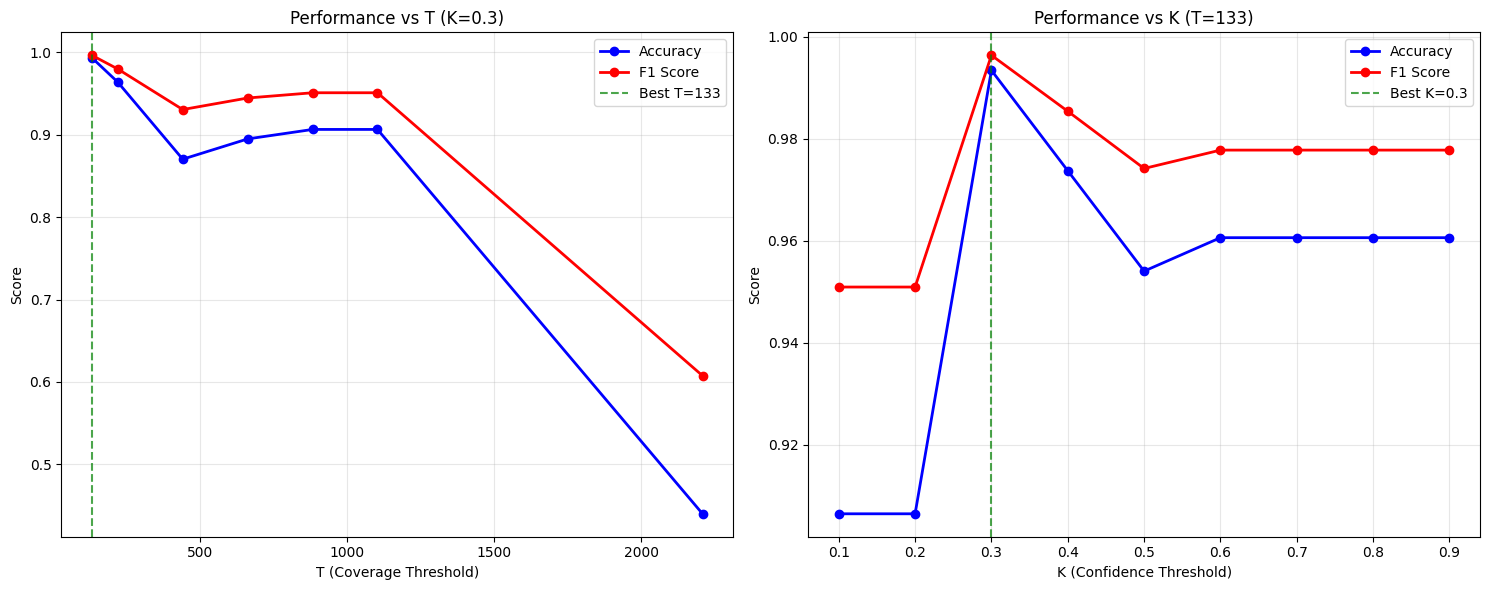

In [ ]:
plot_best_hyperparameters_performance(results_df, best_params)

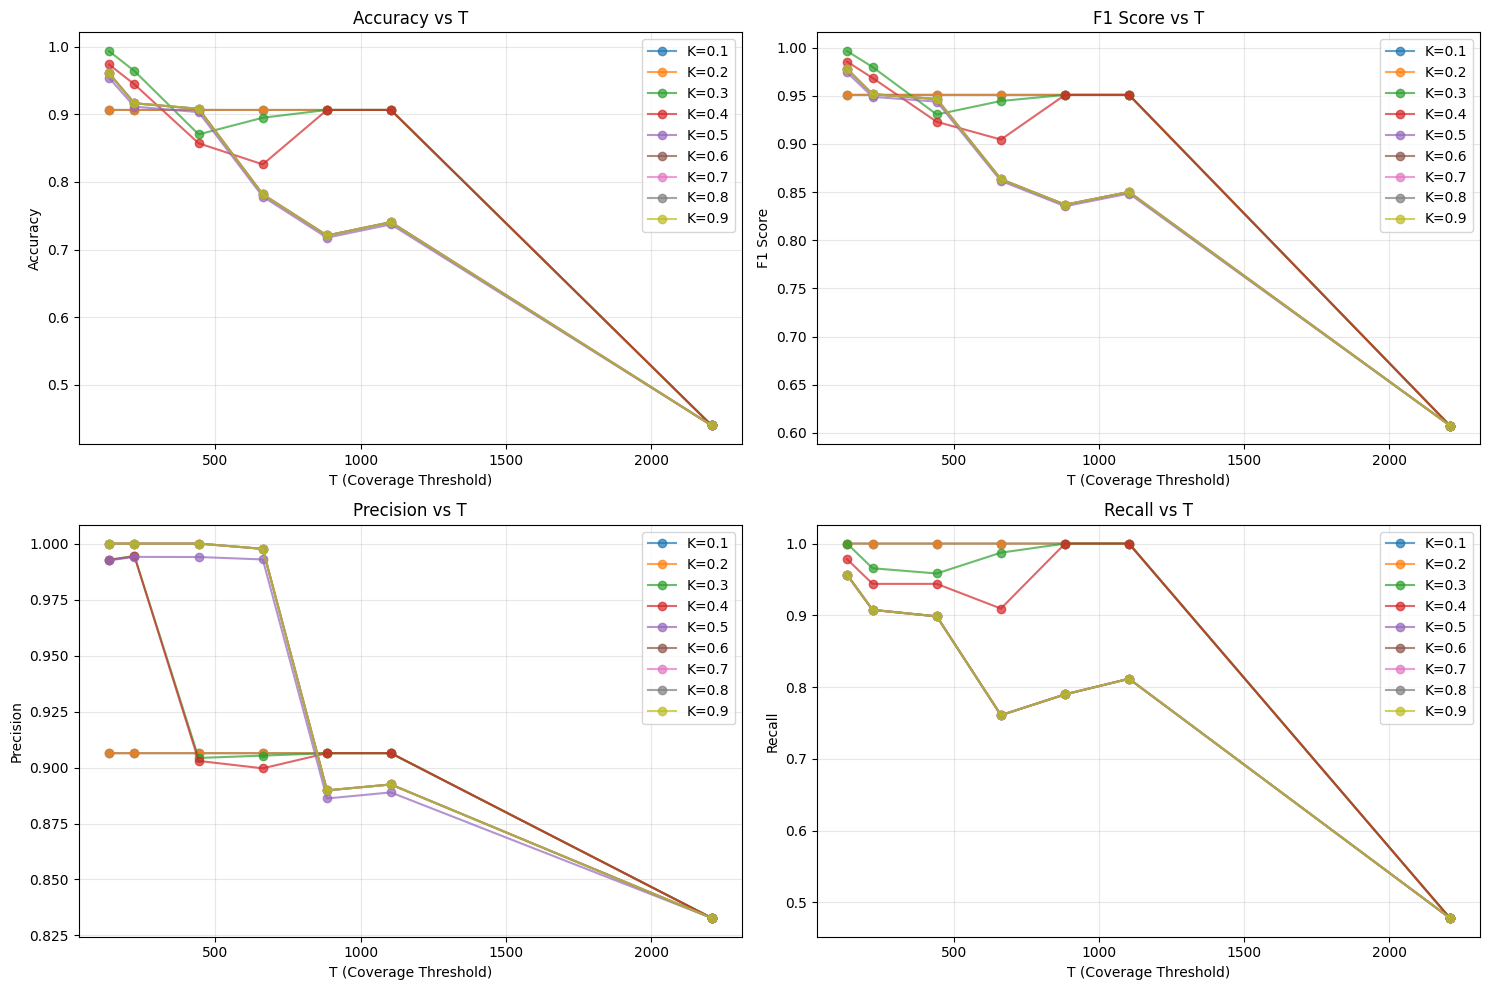

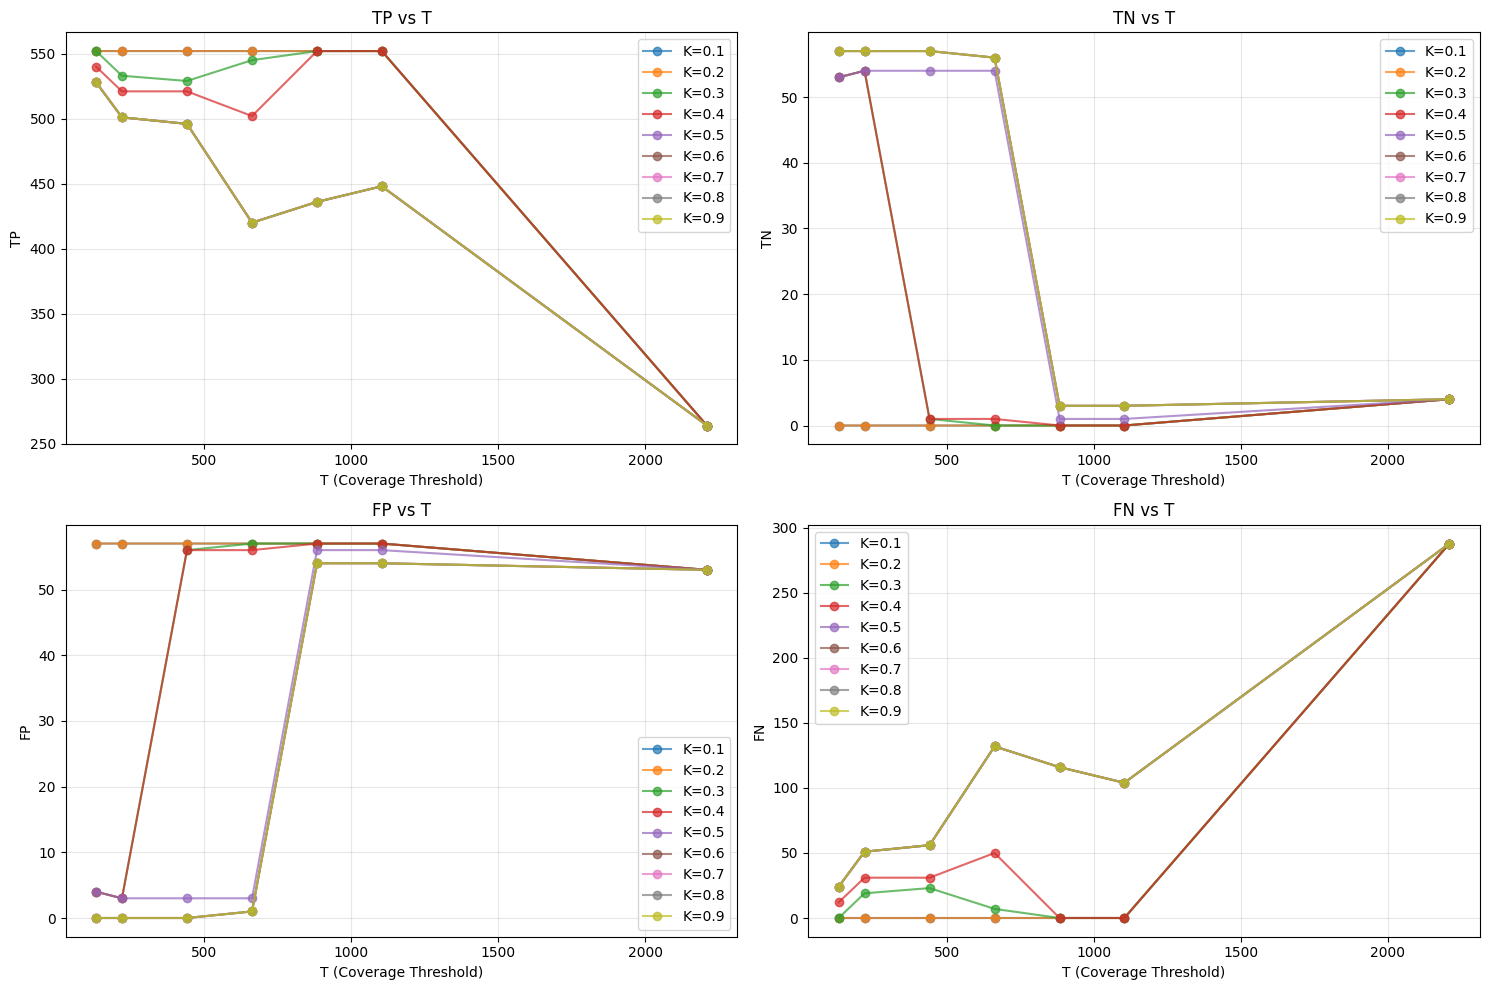

In [ ]:
plot_hyperparameter_results(results_df)

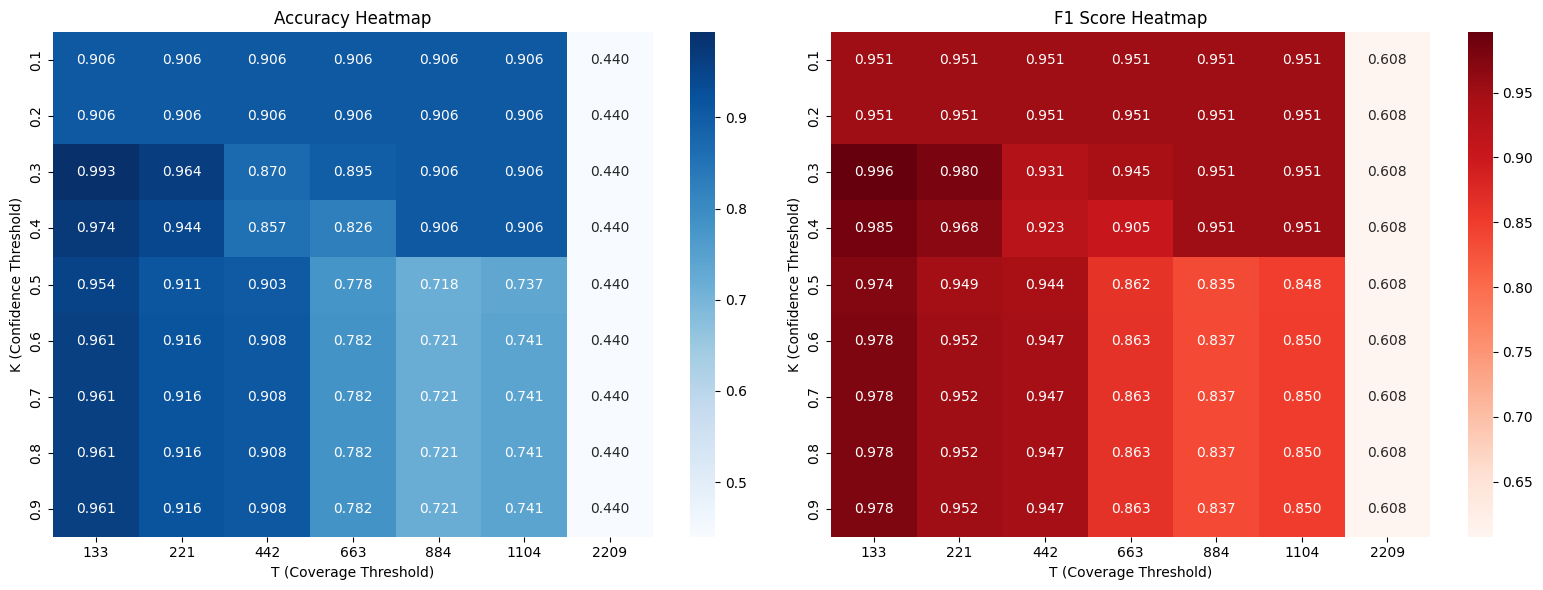


8. Summary Statistics:
Total parameter combinations tested: 72
Successful combinations (rules generated): 63
Success rate: 87.5%

Performance ranges:
Accuracy: 0.440 - 0.993
F1 Score: 0.608 - 0.996
Rules count: 1 - 40


In [ ]:
plot_all_combinations_heatmap(results_df)
print_summary_statistics(results_df)

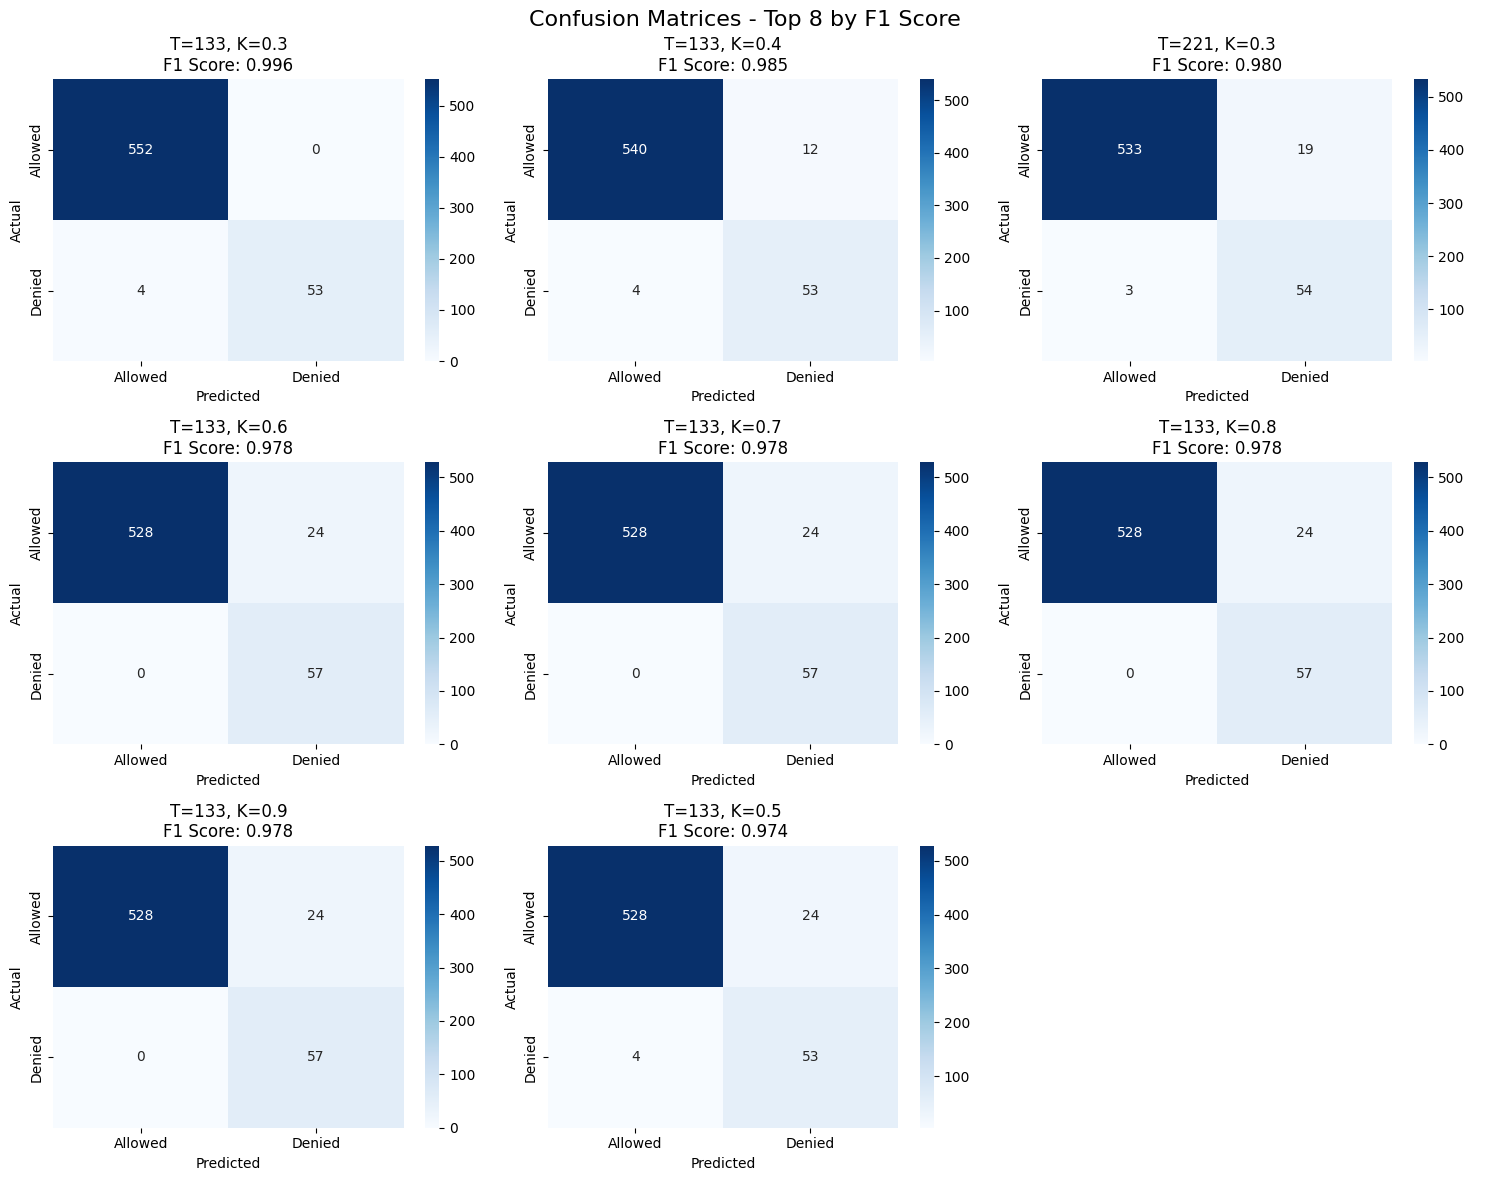

In [ ]:
plot_confusion_matrices(results_df, metric='f1_score', top_n=8)

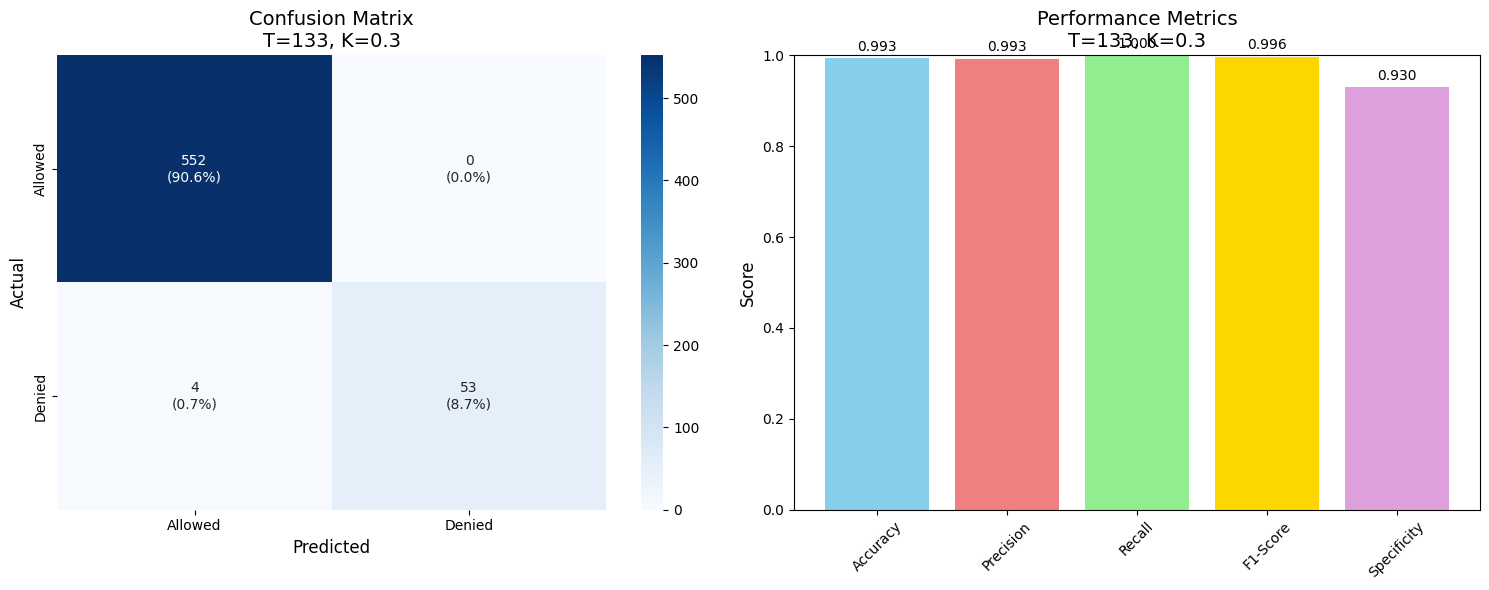


Detailed Classification Report for T=133, K=0.3:
              precision    recall  f1-score   support

      Denied       1.00      0.93      0.96        57
     Allowed       0.99      1.00      1.00       552

    accuracy                           0.99       609
   macro avg       1.00      0.96      0.98       609
weighted avg       0.99      0.99      0.99       609


Confusion Matrix Breakdown:
True Negatives (TN):  53 - Correctly predicted denials
False Positives (FP): 4 - Incorrectly predicted as allowed
False Negatives (FN): 0 - Incorrectly predicted as denied
True Positives (TP):  552 - Correctly predicted allowed
Total Rules Generated: 26
No results found for T=6776, K=0.6


In [ ]:
plot_detailed_confusion_matrix(results_df, best_params['f1_score']['T'], best_params['f1_score']['K'])

#### Test Run

In [ ]:
# Enhanced main function with testing
def run_rhapsody_with_testing(data_path, T, K, run_testing=True):
    """
    Run RHAPSODY algorithm with comprehensive testing
    """
    print(f"Running Rhapsody Algorithm with T={T}, K={K}")
    print("\nParameter Guidelines:")
    print(f"T={T}: Rules must cover at least {T} requests")
    print(f"K={K}: Rules must have at least {K*100}% reliability")

    try:
        # Run RHAPSODY algorithm
        final_rules, nUP, nA = rhapsody_algorithm(data_path, T, K)
        display_results(final_rules, nUP, nA, "FINAL RHAPSODY RULES")

        if run_testing and final_rules:
            # Run comprehensive testing
            print("\n" + "=" * 60)
            print("STARTING COMPREHENSIVE RULE TESTING")
            print("=" * 60)

            test_path = testpath
            # Check if augmented test data exists
            if not os.path.exists(test_path):
                print(f"Augmented test data not found at {test_path}")
                print("Please run data augmentation first or provide the correct path")
                return rules, nUP, nA, None

            tester = RHAPSODYTester(test_path, final_rules, nUP, nA, T, K)
            evaluation_results = tester.run_complete_evaluation()

            return final_rules, nUP, nA, evaluation_results, tester
        else:
            if not final_rules:
                print("\nNo rules generated - skipping testing")
            return final_rules, nUP, nA, None

    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None, None

In [ ]:
data_path = trainpath
T = best_params['f1_score']['T'] # Minimum request coverage threshold best_T
K = best_params['f1_score']['K'] # Reliability threshold best_K

if not os.path.exists(data_path):
    print(f"File not found: {data_path}")
    print("Please check the file path. Available files in the directory:")
    directory = os.path.dirname(data_path)
    if os.path.exists(directory):
        files = [f for f in os.listdir(directory) if f.endswith('.csv')]
        for file in files:
            print(f"  - {file}")
    else:
        print(f"Directory does not exist: {directory}")
    print("\nPlease update the data_path variable with the correct file path.")
else:
    # Run RHAPSODY with comprehensive testing
    rules, nUP, nA, test_results, tester = run_rhapsody_with_testing(data_path, T, K, run_testing=True)


    if test_results:
        print("\n" + "=" * 60)
        print("TESTING COMPLETED SUCCESSFULLY!")
        print("=" * 60)
        print("Results saved in test_results dictionary")

    else:
        print("Testing was skipped or failed")

Running Rhapsody Algorithm with T=973, K=0.4

Parameter Guidelines:
T=973: Rules must cover at least 973 requests
K=0.4: Rules must have at least 40.0% reliability
Loaded 4419 records

=== STAGE 1: Computing Frequent Rules ===

=== STAGE 2: Computing Reliable Rules ===

=== STAGE 3: Removing Redundant Rules ===
Final concise rules: 10



FINAL RHAPSODY RULES:
user_role=registrar  |  nU×P: 1153  |  nA: 1153
crs_taught=NOT_crs ∧ resource_type=student_application  |  nU×P: 1231  |  nA: 1231
crs_taught=NOT_crs ∧ user_role=admissions  |  nU×P: 1231  |  nA: 1231
resource_type=gradebook ∧ user_role=student  |  nU×P: 1262  |  nA: 1262
crs_taught=NOT_crs ∧ operation=read  |  nU×P: 1350  |  nA: 1350
resource_type=gradebook  |  nU×P: 1426  |  nA: 1426
user_role=student  |  nU×P: 1468  |  nA: 1469
user_role=admissions  |  nU×P: 1475  |  nA: 1476
resource_type=student_application  |  nU×P: 1605  |  nA: 1605
operation=read  |  nU×P: 1856  |  nA: 1856

STARTING COMPREHENSIVE RULE TESTING
Starting RHA

##### Data Visualization

In [ ]:
# Functions for data visualization and analysis
def plot_confusion_matrices(confusion_matrix, labels=['allow', 'deny'], title='Confusion Matrix'):
    """Plot confusion matrix"""
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def plot_metrics_comparison(results_dict, title='Performance Metrics Comparison'):
    """Plot comparison of metrics across different categories"""
    metrics = ['accuracy', 'precision', 'recall', 'f1_score']
    categories = list(results_dict.keys())

    fig, ax = plt.subplots(figsize=(12, 6))

    x = np.arange(len(categories))
    width = 0.15
    colors = ['#1f77b4', '#76b7b2', '#aec7e8', '#c7d6eb'] #shades of blue

    for i, metric in enumerate(metrics):
        values = [results_dict[cat].get(metric, 0) for cat in categories]
        ax.bar(x + i * width, values, width/1.25, label=metric.capitalize(), color=colors[i])

    ax.set_xlabel('Categories')
    ax.set_ylabel('Score')
    ax.set_title(title)
    ax.set_xticks(x + width * 1.5)
    ax.set_xticklabels(categories)
    ax.legend()
    ax.set_ylim(0, 1)

    plt.tight_layout()
    plt.show()


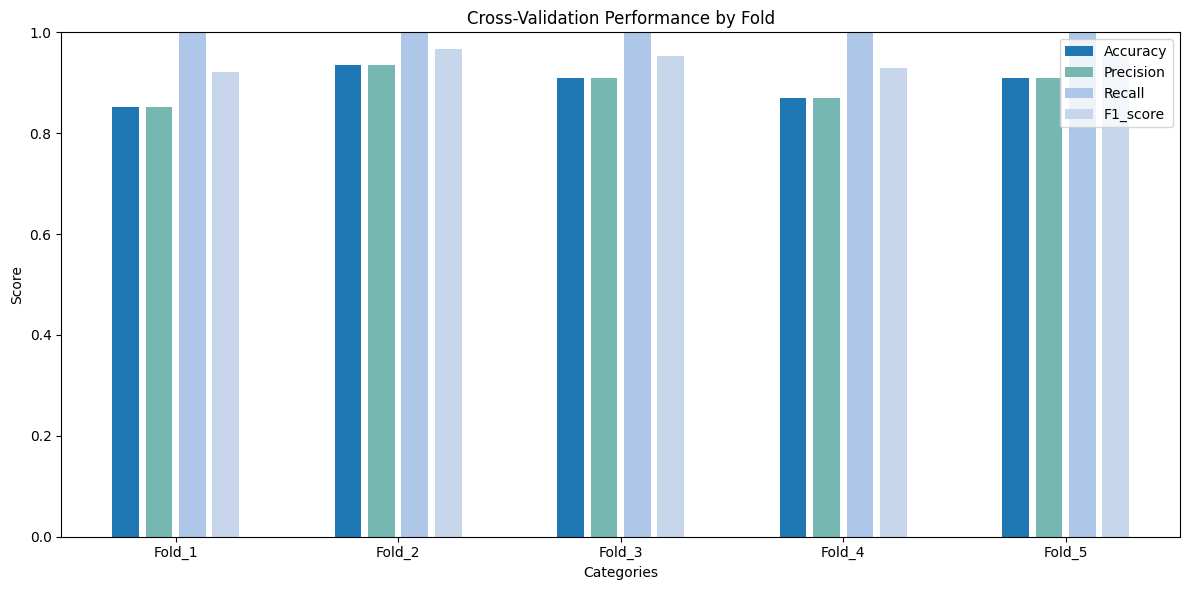

In [ ]:
if 'cv_results' in test_results and test_results['cv_results']:
        fold_results = test_results['cv_results']['fold_results']
        fold_dict = {f"Fold_{fold['fold']}": fold for fold in fold_results}
        plot_metrics_comparison(
            fold_dict,
            title='Cross-Validation Performance by Fold'
        )

In [ ]:
import json
import numpy as np

def convert_np(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, np.generic):
        return obj.item()
    elif isinstance(obj, dict):
        return {convert_np(k): convert_np(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_np(elem) for elem in obj]
    else:
        return obj

# Convert your test_results before saving
cleaned_results = convert_np(test_results)

filename = f"test_results_T{T}_K{K}.json"
with open(filename, "w") as f:
    json.dump(cleaned_results, f, indent=4)

In [ ]:
end_time = time.time()
elapsed_time = end_time - start_time

print(f"Elapsed time: {elapsed_time / 60:.4f} minutes")
print('End: ', time.ctime(end_time))

Elapsed time: 0.9883 minutes
End:  Fri Jul 25 17:49:11 2025
